<a href="https://colab.research.google.com/github/yunhonghe/realtime-dreamer/blob/main/Sentiment_Analysis_BERT_Model_batch_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install transformers
!pip install torch
!pip install openpyxl
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 55.7 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!nvidia-smi

Wed Aug  3 17:53:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import random
import re
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import transformers
from collections import defaultdict
from torch import nn, optim, tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification,BertTokenizer,BertModel,AutoModel, AutoTokenizer,AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from google.colab import files
import altair as alt
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [5]:
RANDOM_SEED = 42
MAX_LEN = 768

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
train_review_df = pd.read_excel(f'drive/MyDrive/Realtime Dreamer/train reviews.xlsx',
                                engine='openpyxl',
                                sheet_name ='train', 
                                skiprows=0)
train_review_df=train_review_df.rename(columns={'Review Content':'Vietnamese'})
print(train_review_df.shape)

(5703, 4)


In [7]:
print('Count of individual class before oversamping negative class:')
print(train_review_df['emotion'].value_counts())
k_neg = len(train_review_df[train_review_df['emotion']=='positive'])\
        -len(train_review_df[train_review_df['emotion']=='negative'])

new_index_neg=random.choices(train_review_df[train_review_df['emotion']=='negative']['index'].values, 
                             k=k_neg)
df_add_neg=pd.DataFrame(new_index_neg,columns=['index'])
df_add_neg_combined=pd.merge(df_add_neg,train_review_df,
                             how='left',
                             on=['index'])
train_review_df=train_review_df.append(df_add_neg_combined).reset_index()
train_review_df.drop(['level_0'],axis=1,inplace=True)
print('\nCount of individual class after oversamping negative class:')
print(train_review_df['emotion'].value_counts())

Count of individual class before oversamping negative class:
positive    5270
neutral      269
negative     164
Name: emotion, dtype: int64

Count of individual class after oversamping negative class:
positive    5270
negative    5270
neutral      269
Name: emotion, dtype: int64


In [8]:
col_name='emotion'
label_dict={'positive': 2, 'neutral': 1, 'negative': 0}
label_dict_inverse = {v: k for k, v in label_dict.items()}

def add_label_to_df(df):
    df['label']=df['emotion'].replace(label_dict)
    df=df[['index','Vietnamese','emotion','label']]
    return df

In [9]:
def data_split(df):
    df=add_label_to_df(df)
    X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                      df['label'].values,
                                                      test_size=0.20,
                                                      random_state=RANDOM_SEED,
                                                      stratify=df['label'].values)
    return X_train, X_val, y_train, y_val

In [10]:
def set_data_category_in_df(df): 
    X_train, X_val, y_train, y_val = data_split(df)
    df['data_category'] = ['unset']*df.shape[0]
    df.loc[X_train, 'data_category'] = 'train'
    df.loc[X_val, 'data_category'] = 'val'
    return df

In [11]:
def encode_data_and_prepare_dataset(df):
    df=set_data_category_in_df(df)
    encoded_data_train = tokenizer.batch_encode_plus(df[df.data_category=='train'].Vietnamese.values,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True,
                                                    padding=True,
                                                    return_tensors='pt')

    encoded_data_val = tokenizer.batch_encode_plus(df[df.data_category=='val'].Vietnamese.values,
                                                  add_special_tokens=True,
                                                  return_attention_mask=True,
                                                  padding=True,
                                                  return_tensors='pt')

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_category=='train']['label'].values) #torch.tensor(y_train)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_category=='val']['label'].values)  #torch.tensor(y_val)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
    return dataset_train,dataset_val 


In [12]:
def build_Bert_model(pre_trained_model,attention_probs_dropout_prob,hidden_dropout_prob):

    model = BertForSequenceClassification.from_pretrained(pre_trained_model, 
                                                          num_labels=len(label_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False,
                                                          hidden_dropout_prob=hidden_dropout_prob,
                                                          attention_probs_dropout_prob=attention_probs_dropout_prob)
    return model

def build_dataloader(df,batch_size):
    dataset_train,dataset_val = encode_data_and_prepare_dataset(df)
    dataloader_train = DataLoader(dataset_train, 
                                  sampler=RandomSampler(dataset_train), 
                                  batch_size=batch_size)
    dataloader_validation = DataLoader(dataset_val, 
                                      sampler=SequentialSampler(dataset_val), 
                                      batch_size=batch_size)
    return dataloader_train,dataloader_validation

def setup_optimizer(Ir,eps):
    optimizer = AdamW(model.parameters(),
                      lr=Ir, 
                      eps=eps)
    return optimizer

def setup_scheduler(optimizer,Ir,eps,epochs):
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_train)*epochs)
    return scheduler

In [13]:
def f1_score_func(preds, labels, average):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, 
                    preds_flat,
                    average=average)

# Plot training and validation loss per epoch
def plot_loss_and_f1_score(df):
    epoch_list = df['epoch'].values
    train_loss = df['train_loss'].values
    validation_loss = df['val_loss'].values
    F1_score_weighted = df['F1_score_weighted'].values
    F1_score_macro = df['F1_score_macro'].values
    F1_score_micro = df['F1_score_micro'].values
    plt.plot(epoch_list,train_loss,'r',label='train loss')
    plt.plot(epoch_list,validation_loss,'b',label='validation loss')
    plt.plot(epoch_list,F1_score_weighted,'g',label='F1 Score (Weighted)')
    plt.plot(epoch_list,F1_score_macro,'yellow',label='F1 Score (macro)')
    plt.plot(epoch_list,F1_score_micro,'orange',label='F1 Score (micro)')
    plt.title('Train loss, Validation loss and F1 Scores')
    plt.figure()

def accuracy_per_class(preds, labels):    

      class_list=[]
      score_list=[]
      preds_flat = np.argmax(preds, axis=1).flatten()
      labels_flat = labels.flatten()
    
      for label in np.unique(labels_flat):
          y_preds = preds_flat[labels_flat==label]
          y_true = labels_flat[labels_flat==label]
          acc= len(y_preds[y_preds==label])/len(y_true)
          class_list.append(label_dict_inverse[label])
          score_list.append(len(y_preds[y_preds==label])/len(y_true))     
          print(f'Class: {label_dict_inverse[label]}')
          print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}, ',\
                '{:.3f}'.format(acc),'\n')
      df=pd.DataFrame(class_list,columns=['class'])
      df['score']=score_list

      return df

def plot_accuray_per_class(df):
    plt.bar(df['class'].values,df['score'].values,color='skyblue', width=0.5)
    plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.5)
    plt.title('Accuracy Per Class')
    plt.show()

In [14]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2],}

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_validation) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [15]:
def train_model(col_name,Ir,eps,epochs,batch_size,dataloader_validation):
    epoch_list=[]
    train_loss=[]
    validation_loss=[]
    F1_score_weighted=[]
    F1_score_macro=[]
    F1_score_micro=[]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = setup_optimizer(Ir,eps)
    
    scheduler = setup_scheduler(optimizer,Ir,eps,epochs)
    
    for epoch in tqdm(range(1, epochs+1)):
        
        epoch_list.append(epoch)
        model.train()
        
        loss_train_total = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
        for batch in progress_bar:

            model.zero_grad()      
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2],
                    }       

            outputs = model(**inputs)
          
            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
        torch.save(model.state_dict(), f'emotion_{col_name}_{model_type}_NLP_{epoch}.model')
            
        tqdm.write(f'\nEpoch {epoch}')
        
        loss_train_avg = loss_train_total/len(dataloader_train)            
        tqdm.write(f'Training loss: {loss_train_avg}')
        train_loss.append(loss_train_avg)

        val_loss, predictions, true_vals = evaluate(dataloader_validation) 
        val_f1_weighted = f1_score_func(predictions, true_vals,'weighted')
        val_f1_macro = f1_score_func(predictions, true_vals,'macro')
        val_f1_micro = f1_score_func(predictions, true_vals,'micro')
        validation_loss.append(val_loss)
        F1_score_weighted.append(val_f1_weighted)
        F1_score_macro.append(val_f1_macro)
        F1_score_micro.append(val_f1_micro)

        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1_weighted}')
        tqdm.write(f'F1 Score (macro): {val_f1_macro}')
        tqdm.write(f'F1 Score (micro): {val_f1_micro}')

    eval_df=pd.DataFrame()
    eval_df[col_name]=col_name
    eval_df['epoch']=epoch_list
    eval_df['train_loss']=train_loss
    eval_df['val_loss']=validation_loss
    eval_df['F1_score_weighted']=F1_score_weighted
    eval_df['F1_score_macro']=F1_score_macro
    eval_df['F1_score_micro']=F1_score_micro
    eval_df['batch_size']=batch_size
    eval_df['Ir']=Ir
    eval_df['eps']=eps
    eval_df['pre_trained_model']=pre_trained_model
    eval_df['hidden_dropout_prob']=hidden_dropout_prob
    eval_df['attention_probs_dropout_prob']=attention_probs_dropout_prob  
    
    return eval_df,model

In [16]:
def predict_text(input_text):
    inputs = tokenizer(input_text.lower(), return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax().item()
    return label_dict_inverse[predicted_class_id]

In [17]:
eval_df_list = []
accuracy_per_class_list = []
model_list = []

In [18]:
df = set_data_category_in_df(train_review_df) 
col_name = 'emotion'
hidden_dropout_prob = 0.1
attention_probs_dropout_prob = 0.1
pre_trained_model = 'trituenhantaoio/bert-base-vietnamese-uncased' 
model_type = pre_trained_model.split('/')[0]
batch_size = 32
epochs = 10
Ir = 1e-5
eps = 1e-8

seed_val = RANDOM_SEED
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

tokenizer = BertTokenizer.from_pretrained( 
                                          pre_trained_model,
                                          do_lower_case=True
                                          )
dataloader_train,dataloader_validation = build_dataloader(df,batch_size)
model = build_Bert_model(pre_trained_model,attention_probs_dropout_prob,hidden_dropout_prob)
eval_df, model = train_model(col_name,Ir,eps,epochs,batch_size,dataloader_validation)

train_data_provider = 'Yunhong He'
eval_df['note'] = 'Added and splited Self-judged Review emotions into train and valiation by 8:2'
eval_df['emotion'] = 'positive,negative,neutral'
eval_df['train_data_creator'] = '''Yunhong'''

eval_df.to_csv(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_NLP_Epoch{epochs}_train_data_provided_by_{train_data_provider}_eval_df.csv',
               index=False)

torch.save(model.state_dict(), f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}.model')
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class_df = accuracy_per_class(predictions, true_vals)
accuracy_per_class_df['pre_trained_model'] = model_type
accuracy_per_class_df['epoch'] = epochs
accuracy_per_class_df['train_data_creator'] = '''Yunhong'''
accuracy_per_class_df.to_csv(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}_accuracy_per_class_df.csv',
                             index=False)
best_epoch_F1_score_macro = eval_df[ eval_df['F1_score_macro']==max(eval_df['F1_score_macro'])]['epoch'].values[0]
print('best epoch for the best F1 score (macro): ',best_epoch_F1_score_macro)
eval_df_list.append(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_NLP_Epoch{epochs}_train_data_provided_by_{train_data_provider}_eval_df.csv')
accuracy_per_class_list.append(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}_accuracy_per_class_df.csv')
model_list.append(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}.model')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at trituenhantaoio/bert-base-vietnamese-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.13603175489912395
Validation loss: 0.021479007558595827
F1 Score (Weighted): 0.9944431547735713
F1 Score (macro): 0.99023345227456
F1 Score (micro): 0.9944495837187789


Epoch 2:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.019121757516683838
Validation loss: 0.027870514356490114
F1 Score (Weighted): 0.9949055002927872
F1 Score (macro): 0.9905495784644858
F1 Score (micro): 0.9949121184088807


Epoch 3:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.009327831041030035
Validation loss: 0.01913941544626141
F1 Score (Weighted): 0.9972171530479589
F1 Score (macro): 0.9921301582420572
F1 Score (micro): 0.9972247918593895


Epoch 4:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0053481683478694125
Validation loss: 0.016464730818637797
F1 Score (Weighted): 0.9972171530479589
F1 Score (macro): 0.9921301582420572
F1 Score (micro): 0.9972247918593895


Epoch 5:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.004226555185368013
Validation loss: 0.025605765618606443
F1 Score (Weighted): 0.9962925044191804
F1 Score (macro): 0.9914979348595717
F1 Score (micro): 0.996299722479186


Epoch 6:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0019491958267908592
Validation loss: 0.023152124803827438
F1 Score (Weighted): 0.9967548303966522
F1 Score (macro): 0.9918140476879381
F1 Score (micro): 0.9967622571692877


Epoch 7:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.000981198533672695
Validation loss: 0.024054287328694687
F1 Score (Weighted): 0.9967548303966522
F1 Score (macro): 0.9918140476879381
F1 Score (micro): 0.9967622571692877


Epoch 8:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.001009750585305862
Validation loss: 0.020154944425431656
F1 Score (Weighted): 0.9976794729967746
F1 Score (macro): 0.9924462669483635
F1 Score (micro): 0.9976873265494912


Epoch 9:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0008128868592131928
Validation loss: 0.020769675516716875
F1 Score (Weighted): 0.9976794729967746
F1 Score (macro): 0.9924462669483635
F1 Score (micro): 0.9976873265494912


Epoch 10:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0007588162939452972
Validation loss: 0.021447156565366585
F1 Score (Weighted): 0.9972171530479589
F1 Score (macro): 0.9921301582420572
F1 Score (micro): 0.9972247918593895
Class: negative
Accuracy: 1054/1054,  1.000 

Class: neutral
Accuracy: 52/54,  0.963 

Class: positive
Accuracy: 1050/1054,  0.996 

best epoch for the best F1 score (macro):  8


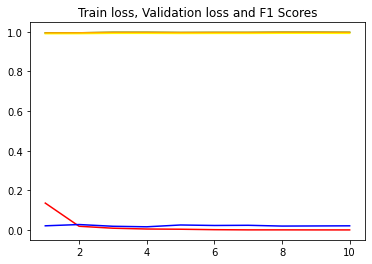

<Figure size 432x288 with 0 Axes>

In [19]:
plot_loss_and_f1_score(eval_df)

In [20]:
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class_df = accuracy_per_class(predictions, true_vals)

Class: negative
Accuracy: 1054/1054,  1.000 

Class: neutral
Accuracy: 52/54,  0.963 

Class: positive
Accuracy: 1050/1054,  0.996 



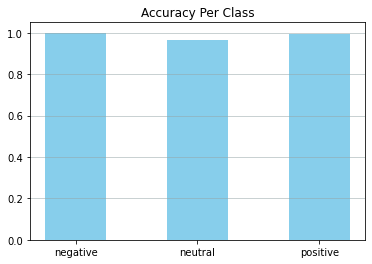

In [21]:
plot_accuray_per_class(accuracy_per_class_df)

In [22]:
test_text_product = 'Sản phẩm rất tốt, và mạnh mẽ'    # Very good product, and powerful
test_text_service = 'Tôi cần ai đó hỗ trợ tôi cách sử dụng'    # I need someone to help me how to use it
test_text_logistic = 'giao hàng quá chậm'    # delivery is too slow
print("Predict emotion: ",predict_text(test_text_product))
print("Predict emotion: ",predict_text(test_text_service))
print("Predict emotion: ",predict_text(test_text_logistic))

Predict emotion:  positive
Predict emotion:  positive
Predict emotion:  negative


In [23]:
df = set_data_category_in_df(train_review_df) 
col_name = 'emotion'
hidden_dropout_prob = 0.1
attention_probs_dropout_prob = 0.1
pre_trained_model = 'trituenhantaoio/bert-base-vietnamese-uncased' 
model_type = pre_trained_model.split('/')[0]
batch_size = 32
epochs = best_epoch_F1_score_macro
Ir = 1e-5
eps = 1e-8

seed_val = RANDOM_SEED
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

tokenizer = BertTokenizer.from_pretrained( 
                                          pre_trained_model,
                                          do_lower_case=True
                                          )
dataloader_train,dataloader_validation = build_dataloader(df,batch_size)
model = build_Bert_model(pre_trained_model,attention_probs_dropout_prob,hidden_dropout_prob)
eval_df, model = train_model(col_name,Ir,eps,epochs,batch_size,dataloader_validation)

train_data_provider = 'Yunhong He'
eval_df['note'] = 'Added and splited Self-judged Review emotions into train and valiation by 8:2'
eval_df['emotion'] = 'positive,negative,neutral'
eval_df['train_data_creator'] = '''Yunhong'''

eval_df.to_csv(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_NLP_Epoch{epochs}_train_data_provided_by_{train_data_provider}_eval_df.csv',index=False)

torch.save(model.state_dict(), f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}.model')
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class_df = accuracy_per_class(predictions, true_vals)
accuracy_per_class_df['pre_trained_model'] = model_type
accuracy_per_class_df['epoch'] = epochs
accuracy_per_class_df['train_data_creator'] = '''Yunhong'''
accuracy_per_class_df.to_csv(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}_accuracy_per_class_df.csv',
                             index=False)
best_epoch_F1_score_macro = eval_df[ eval_df['F1_score_macro']==max(eval_df['F1_score_macro'])]['epoch'].values[0]
print('best epoch for the best F1 score (macro): ',best_epoch_F1_score_macro)
eval_df_list.append(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_NLP_Epoch{epochs}_train_data_provided_by_{train_data_provider}_eval_df.csv')
accuracy_per_class_list.append(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}_accuracy_per_class_df.csv')
model_list.append(f'/content/drive/MyDrive/Realtime Dreamer/train_review_{model_type}_train_data_provided_by_{train_data_provider}_NLP_Epoch{epochs}.model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at trituenhantaoio/bert-base-vietnamese-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.1358979962065101
Validation loss: 0.022519463195588767
F1 Score (Weighted): 0.9944431547735713
F1 Score (macro): 0.99023345227456
F1 Score (micro): 0.9944495837187789


Epoch 2:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.01823304832815897
Validation loss: 0.03365819110459758
F1 Score (Weighted): 0.9935179681981843
F1 Score (macro): 0.9867009690281164
F1 Score (micro): 0.9935245143385754


Epoch 3:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.008954988220234907
Validation loss: 0.02103321416336043
F1 Score (Weighted): 0.9972171530479589
F1 Score (macro): 0.9921301582420572
F1 Score (micro): 0.9972247918593895


Epoch 4:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.005208093685878104
Validation loss: 0.020259129851825385
F1 Score (Weighted): 0.9967548303966522
F1 Score (macro): 0.9918140476879381
F1 Score (micro): 0.9967622571692877


Epoch 5:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.004679551274525139
Validation loss: 0.021196859917408266
F1 Score (Weighted): 0.9967548303966522
F1 Score (macro): 0.9918140476879381
F1 Score (micro): 0.9967622571692877


Epoch 6:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0020781022699389133
Validation loss: 0.025098453159230035
F1 Score (Weighted): 0.9967548303966522
F1 Score (macro): 0.9918140476879381
F1 Score (micro): 0.9967622571692877


Epoch 7:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0017953238465455515
Validation loss: 0.022607690064058474
F1 Score (Weighted): 0.9972171530479589
F1 Score (macro): 0.9921301582420572
F1 Score (micro): 0.9972247918593895


Epoch 8:   0%|          | 0/271 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.000915398912949357
Validation loss: 0.023305988748581835
F1 Score (Weighted): 0.9972171530479589
F1 Score (macro): 0.9921301582420572
F1 Score (micro): 0.9972247918593895
Class: negative
Accuracy: 1054/1054,  1.000 

Class: neutral
Accuracy: 52/54,  0.963 

Class: positive
Accuracy: 1050/1054,  0.996 

best epoch for the best F1 score (macro):  3


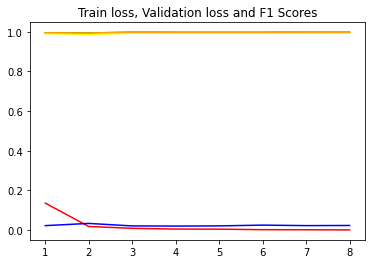

<Figure size 432x288 with 0 Axes>

In [24]:
plot_loss_and_f1_score(eval_df)

In [25]:
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class_df = accuracy_per_class(predictions, true_vals)

Class: negative
Accuracy: 1054/1054,  1.000 

Class: neutral
Accuracy: 52/54,  0.963 

Class: positive
Accuracy: 1050/1054,  0.996 



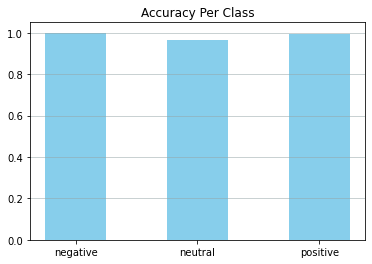

In [26]:
plot_accuray_per_class(accuracy_per_class_df)

In [27]:
test_text_product = 'Sản phẩm rất tốt, và mạnh mẽ'    # Very good product, and powerful
test_text_service = 'Tôi cần ai đó hỗ trợ tôi cách sử dụng'    # I need someone to help me how to use it
test_text_logistic = 'giao hàng quá chậm'    # delivery is too slow
print("Predict emotion: ",predict_text(test_text_product))
print("Predict emotion: ",predict_text(test_text_service))
print("Predict emotion: ",predict_text(test_text_logistic))

Predict emotion:  positive
Predict emotion:  positive
Predict emotion:  negative


In [28]:
review_df = pd.read_excel(f'drive/MyDrive/Realtime Dreamer/reviews.xlsx',
                          engine='openpyxl',
                          sheet_name ='LZD R&R raw')
print(review_df.shape)

review_df = review_df.reset_index()
review_df_1 = review_df[['index','Review Content','Rating']].dropna(how='any')
review_df_1['Review Content'] = review_df_1['Review Content'].astype('string')
review_df_2 = review_df_1[review_df_1['Review Content'].isnull()==False]
print(review_df_2.shape)

review_df_2[col_name] = review_df_2['Review Content'].apply(predict_text)
review_df_2.to_csv(f'/content/drive/MyDrive/Realtime Dreamer/predict_emotion in review_{model_type}_epoch{epochs}_train_data_provided_by_{train_data_provider}.csv',
                   index=False)

(23535, 18)
(21052, 3)


In [29]:
pre_trained_model = 'trituenhantaoio/bert-base-vietnamese-uncased' 
model_type = pre_trained_model.split('/')[0]
epochs = 3
train_data_provider = 'Yunhong He'
review_emotion_predict=pd.read_csv(f'/content/drive/MyDrive/Realtime Dreamer/predict_emotion in review_{model_type}_epoch{epochs}_train_data_provided_by_{train_data_provider}.csv')
print(review_emotion_predict.shape)
print(review_emotion_predict.emotion.value_counts())

(21052, 4)
positive    12956
neutral      7048
negative     1048
Name: emotion, dtype: int64


In [30]:
review_df = pd.read_excel(f'drive/MyDrive/Realtime Dreamer/reviews.xlsx',
                          engine='openpyxl',
                          sheet_name ='LZD R&R raw')
review_df = review_df.reset_index()
review_emotion_prediction=pd.merge(review_df, review_emotion_predict[['index','emotion']], how='left', on='index')
review_emotion_prediction.to_csv(f'/content/drive/MyDrive/Realtime Dreamer/review_emotion_prediction.csv',index=False)